In [44]:
!pip install tensorflow opencv-python matplotlib



In [45]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
Automat                      22.10.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
constantly                   15.1.0
contourpy                    1.1.0
cryptography                 41.0.1
cssselect                    1.2.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
de

In [46]:
import tensorflow as tf
import os

In [47]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
tf.config.list_physical_devices('GPU')

[]

In [49]:
import cv2
import imghdr

In [50]:
import os

data_dir = r'C:\image_classification\data'
os.listdir(data_dir)



['happy', 'sad']

In [51]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [52]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [53]:
import numpy as np
from matplotlib import pyplot as plt

In [54]:
data = tf.keras.utils.image_dataset_from_directory(r'C:\image_classification\data') #building the data pipeline 
#used to create a tf.data.Dataset object from image files in a directory. The function automatically labels the data based on subdirectories in the provided directory

Found 176 files belonging to 2 classes.


In [55]:
data_iterator = data.as_numpy_iterator() #allowing us to access the data pipeline by looping through it

In [56]:
batch = data_iterator.next() #grabbing one particular batch (useful for large amounts of data)

In [57]:
batch[0].shape #represent the image size

(32, 256, 256, 3)

In [58]:
batch[1] #represent the labels 1 is for sad people, 0 is for happy people

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0])

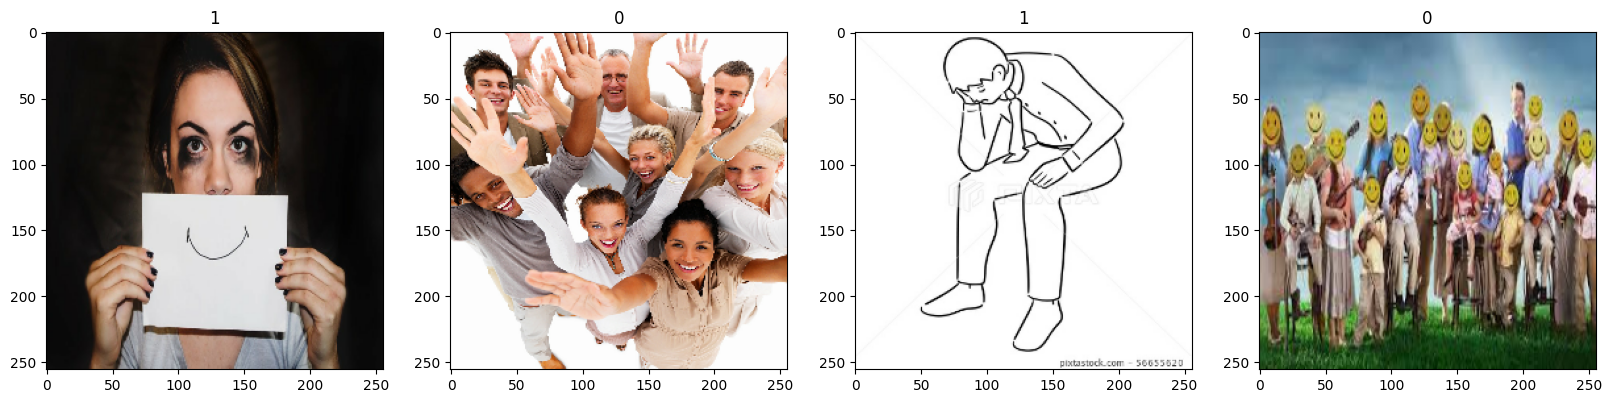

In [59]:
#this code snippet creates a set of subplots arranged in a 1x4 grid, displays the first 4 images from the batch variable on these subplots, and sets the titles of the subplots to their corresponding labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int)) #converts image data type to int data type for compatibility 
    ax[idx].title.set_text(batch[1][idx]) #sets the title of the images according to their label 

In [60]:
data = data.map(lambda x,y: (x/255, y))
# map function allows you to apply a function to each element in a dataset 
# lambda function takes two arguments x and y where x represents images in the dataset and y represents corresponding labels 
# The lambda function divides each image by 255 to perform normalization. The values of the image pixels are typically in the range [0, 255], so dividing by 255 scales them to the range [0, 1]
# returns a tuple where the first element is the normalized image x/255, and the second element is the unchanged label y 

In [61]:
scaled_iterator=data.as_numpy_iterator()

In [62]:
batch=scaled_iterator.next()

In [63]:
batch[0].min() #scaling data-making sure images are between 0 and 1 by dividing by 255 (max range)

0.0

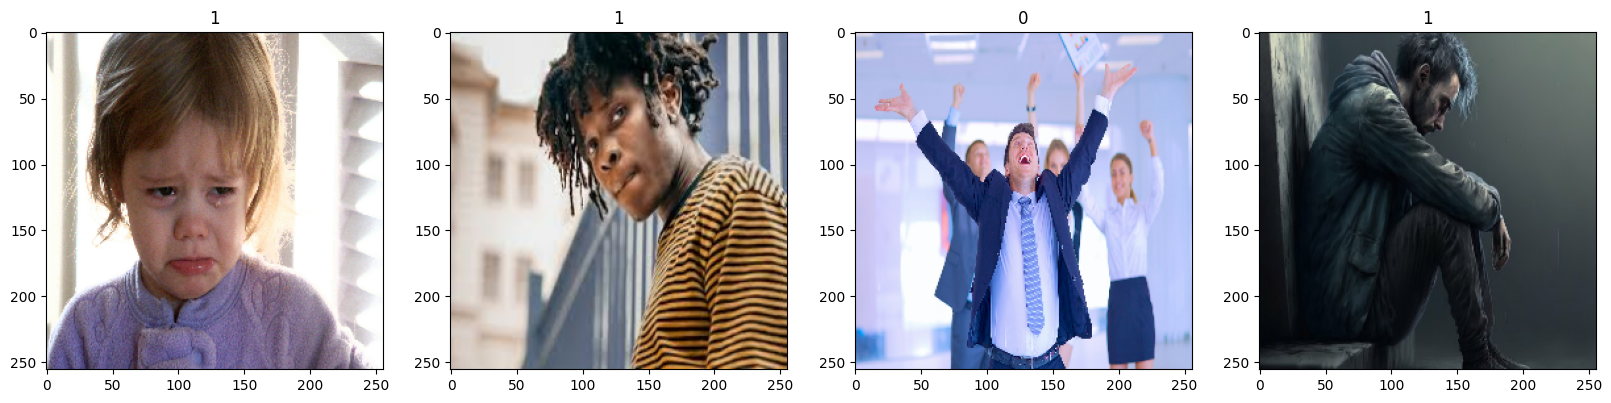

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #in this case if we convert it into int type, images will be black and white 
    ax[idx].title.set_text(batch[1][idx]) #sets the title of the images according to their label 

In [65]:
train_size = int(len(data)*.7) # training our data
val_size = int(len(data)*.2)+1 # evaluate our model while we are training
test_size = int(len(data)*.1)+1 # testing our model

In [66]:
train_size+val_size+test_size

7

In [67]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [68]:
from tensorflow.keras.models import Sequential # Sequential class is a linear stack of layers used to build neural networks. It allows you to create models where each layer has exactly one input tensor and one output tensor, making it suitable for building simple sequential models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten # Conv2D is a 2D convolution layer, MaxPooling2D- goes through your images and condenses them, Dense- fully connected layer available through keras, Flatten- reduces channel into a format of one ouput which dense layer will be able to take, dropout- used for regularisation 

In [69]:
model = Sequential()

In [70]:
# 16 filters, filter will be 3 pixel by 3 pixel in size, stride of 1 (movie 1 pixel each time)
# activations- relu and sigmoid (we take our data or all of the output from a layer and we pass it through these functions to modify what our output looks like)
# 256 pixels high, 256 pixels wide and 3 channels deep 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #going to take maximum value after relu activation and return that value 

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
#fully connected layers
model.add(Dense(256, activation='relu')) # 256 neurons
model.add(Dense(1, activation='sigmoid')) #single dense layer (we will get a single output, output will represent 0 or 1 as it is a sigmoid activation)

In [71]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# 'adam' refers to the Adam optimizer, which is a popular optimization algorithm used in deep learning
# set the loss function for the model, Binary cross-entropy is commonly used for binary classification problems, where the model is trained to classify input into two classes
# Accuracy is a common metric for classification tasks, measuring the percentage of correctly predicted samples

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [73]:
logdir='logs'

In [74]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# TensorBoard class in the callbacks module of the TensorFlow Keras library. It is used to create an instance of the TensorBoard callback.
# the log_dir parameter specifies the directory where the callback will write the logs and event files for TensorBoard

In [75]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# epochs, which determines how many times the model will iterate over the entire training dataset during training. In this case, the model will be trained for 20 epochs.
# callbacks=[tensorboard_callback]: This argument specifies the callbacks that will be used during training. In this case, it includes a single callback, tensorboard_callback, which is the instance of the TensorBoard callback that was created earlier.

Epoch 1/20


4/4 [==============================] - 8s 1s/step - loss: 1.0524 - accuracy: 0.5078 - val_loss: 0.5918 - val_accuracy: 0.6042
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 0.6565 - accuracy: 0.5469 - val_loss: 0.5961 - val_accuracy: 0.6458
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.5851 - accuracy: 0.6328 - val_loss: 0.4985 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.5532 - accuracy: 0.7422 - val_loss: 0.4914 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.5224 - accuracy: 0.7500 - val_loss: 0.3702 - val_accuracy: 0.9375
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.3915 - accuracy: 0.8594 - val_loss: 0.4008 - val_accuracy: 0.8333
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3483 - accuracy: 0.9141 - val_loss: 0.5107 - val_accuracy: 0.7500
Epoch 8/20
4/4 [==============================] - 6s

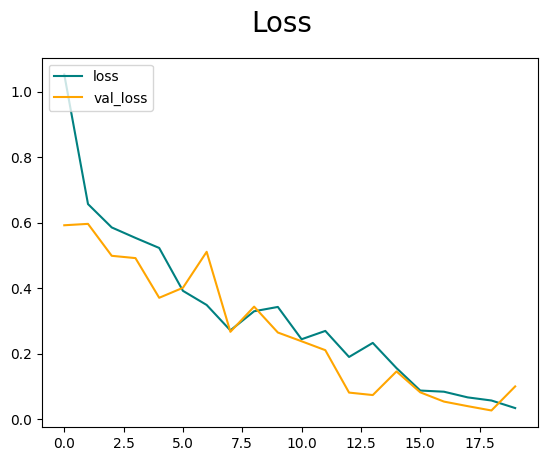

In [76]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

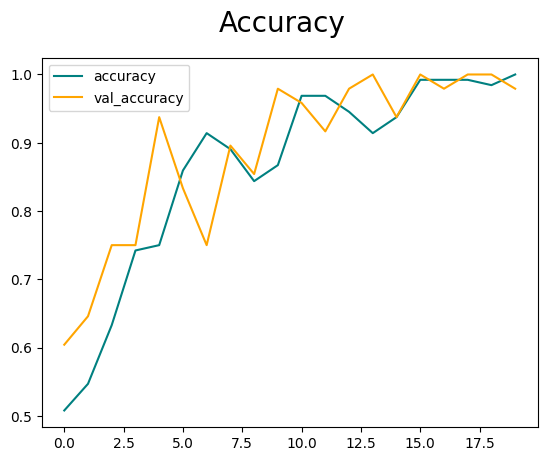

In [77]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [78]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [79]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [80]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
# The code updates the metric states using the predicted values (yhat) and the actual labels (y). This is done using the update_state() method of each metric object. The metrics are updated batch-wise for the given test dataset

In [81]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [95]:
import cv2

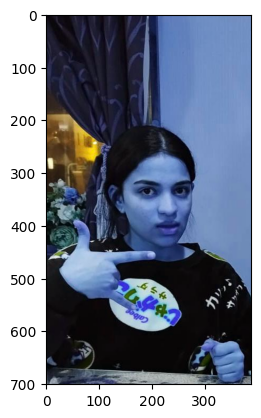

In [106]:
img = cv2.imread(r"C:\image_classification\test4.jpeg")
plt.imshow(img)
plt.show()

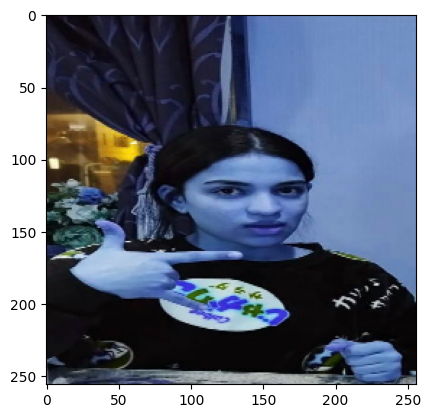

In [107]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [108]:
yhat = model.predict(np.expand_dims(resize/255, 0))
# np.expand_dims() is a function from the NumPy library (np is typically an alias for numpy). It is used to add an extra dimension to an array. In this case, np.expand_dims(resize/255, 0) adds an extra dimension to the normalized image array. The resulting array has shape (1, H, W, C), where H, W, and C represent the height, width, and channels of the image
# model.predict() is a method used to make predictions with a machine learning model. It takes the normalized and expanded image array as input and returns the predicted output

1/1 [==============================] - 0s 32ms/step


In [109]:
yhat

array([[0.00709048]], dtype=float32)

In [110]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
